# Part 2
---

In [1]:
#Import and configure
%matplotlib inline
import cv2
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 13.0)    #adjust plotted images size

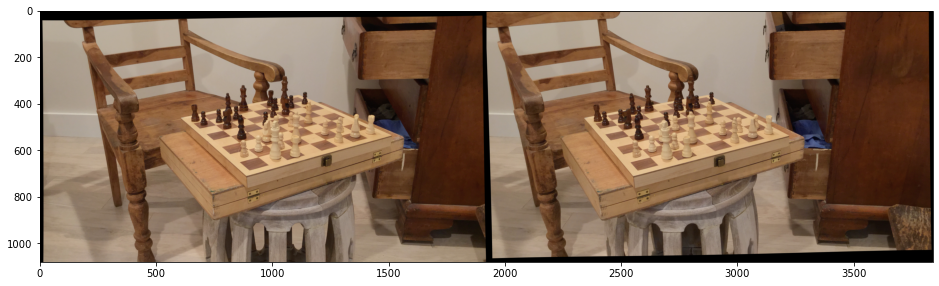

In [2]:
#read left and right images from folder

iml = cv2.imread('stereo/calibrated_source/chess/im0.png')
imr = cv2.imread('stereo/calibrated_source/chess/im1.png')
im=np.concatenate((iml,imr),1)
im= im[:,:,::-1]
plt.imshow(im)
plt.show()    #let's take a look at original images

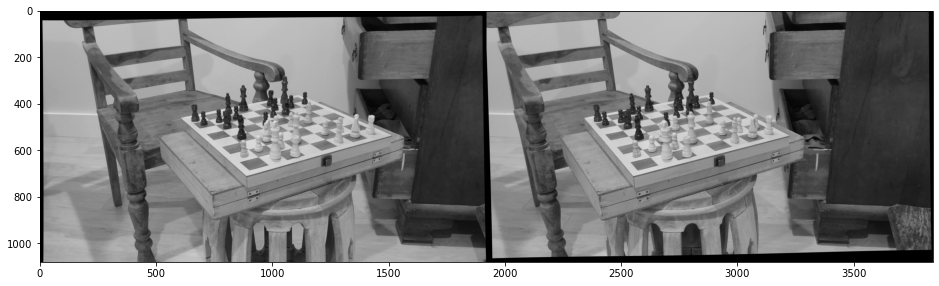

In [3]:
#define our camera intrinsic matrix
left_matrix=np.array([[3979.911,0,1244.772],
                     [0,3979.911,1019.507],
                     [0,0,1]])
right_matrix=np.array([[3979.911,0,1369.115],
                     [0,3979.911,1019.507],
                     [0,0,1]])
#define camera distortion
# distortion=np.array([0.1123524,-0.14519944,0.00040207,0.00042764,0.])
distortion=np.array([0.,0.,0.,0.,0.])

iml_gray = cv2.cvtColor(iml,cv2.COLOR_BGR2GRAY)
imr_gray = cv2.cvtColor(imr,cv2.COLOR_BGR2GRAY)

#undistort two images
h,  w = iml_gray.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(left_matrix,distortion,(w,h),1,(w,h))
iml_gray_un = cv2.undistort(iml_gray, left_matrix, distortion, distortion, newcameramtx)
imr_gray_un = cv2.undistort(imr_gray, right_matrix, distortion, distortion, newcameramtx)
# crop the image
x,y,w,h = roi
iml_gray_un = iml_gray_un[y:y+h, x:x+w]
imr_gray_un= imr_gray_un[y:y+h, x:x+w]
im=np.concatenate((iml_gray,imr_gray),1)
plt.imshow(im,cmap="gray")
plt.show()

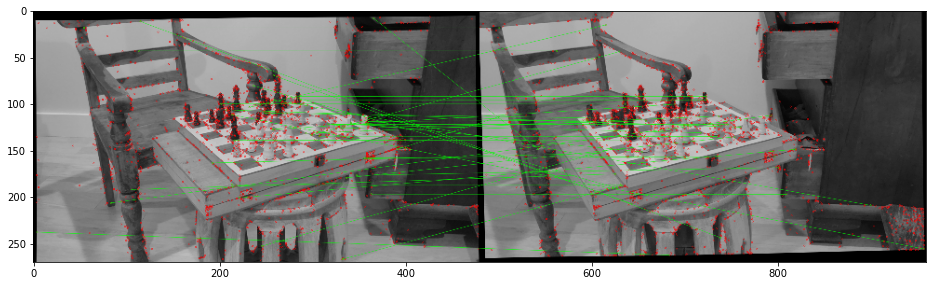

In [4]:
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(iml_gray, None)
kp2, des2 = sift.detectAndCompute(imr_gray, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.3*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[:1600],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    iml_gray, kp1, imr_gray, kp2, random.choices(matches,k=1600), None, **draw_params)

n,m,_=keypoint_matches.shape
new=cv2.resize(keypoint_matches,(int(m/4),int(n/4)))
plt.imshow(new)
plt.show()

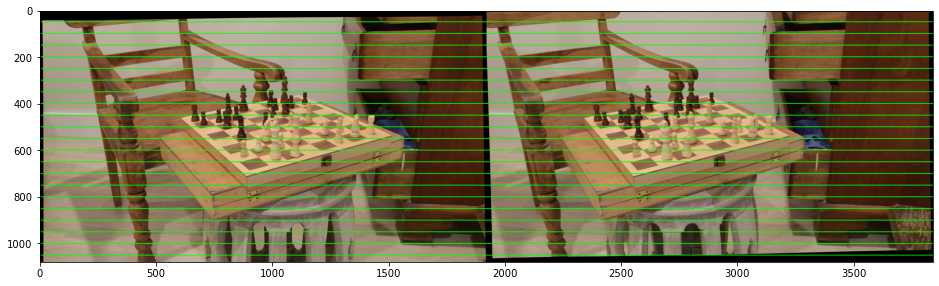

In [5]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]


# Stereo rectification
h1, w1 = iml_gray.shape
h2, w2 = imr_gray.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Undistort (rectify) the images
c=np.linalg.norm((np.array(H1[:3,-1]).reshape(1,3),np.array(H2[:3,-1]).reshape(1,3)))
img1_rectified = cv2.warpPerspective(iml, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(imr, H2, (w2, h2))

# image rectification check
def draw_line(image1, image2):
    height = max(image1.shape[0], image2.shape[0])
    width = image1.shape[1] + image2.shape[1]
    output = np.zeros((height, width, 3), dtype=np.uint8)
    output[0:image1.shape[0], 0:image1.shape[1]] = image1
    output[0:image2.shape[0], image1.shape[1]:] = image2
    # Draw equidistant parallel lines
    line_interval = 50  # interval：50
    for k in range(height // line_interval):
        cv2.line(output, (0, line_interval * (k + 1)), (2 * width, line_interval * (k + 1)), (0, 255, 0), thickness=2,
                 lineType=cv2.LINE_AA)
    return output

img1_rectified,img2_rectified=iml,imr # Our image has been already undistorted, so we use original images here
line = draw_line(img1_rectified, img2_rectified)
im= line[:,:,::-1]
plt.imshow(im)
plt.show()

In [6]:
# we define a pre-processing function to eliminate the effect of uneven light and some other factors
def preprocess(img1, img2):
    # color to gray
    if (img1.ndim == 3):
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if (img2.ndim == 3):
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Histogram mean
    img1 = cv2.equalizeHist(img1)
    img2 = cv2.equalizeHist(img2)
    return img1, img2

In [7]:
# finding disparity
def stereoMatchSGBM(left_image, right_image, down_scale=False):
    # SGBM parameters setting
    if left_image.ndim == 2:
        img_channels = 1
    else:
        img_channels = 3
    blockSize = 3
    paraml = {'minDisparity': 0,
              'numDisparities': 128,
              'blockSize': blockSize,
              'P1': 8 * img_channels * blockSize ** 2,
              'P2': 64 * img_channels * blockSize ** 2,
              'disp12MaxDiff': 1,
              'preFilterCap': 63,
              'uniquenessRatio': 15,
              'speckleWindowSize': 100,
              'speckleRange': 1,
              'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
              }

    # generate a SGBM object
    left_matcher = cv2.StereoSGBM_create(**paraml)
    paramr = paraml
    paramr['minDisparity'] = -paraml['numDisparities']
    right_matcher = cv2.StereoSGBM_create(**paramr)

    # computing disparity map
    size = (left_image.shape[1], left_image.shape[0])
    if down_scale == False:
        disparity_left = left_matcher.compute(left_image, right_image)
        disparity_right = right_matcher.compute(right_image, left_image)

    else:
        left_image_down = cv2.pyrDown(left_image)
        right_image_down = cv2.pyrDown(right_image)
        factor = left_image.shape[1] / left_image_down.shape[1]

        disparity_left_half = left_matcher.compute(left_image_down, right_image_down)
        disparity_right_half = right_matcher.compute(right_image_down, left_image_down)
        disparity_left = cv2.resize(disparity_left_half, size, interpolation=cv2.INTER_AREA)
        disparity_right = cv2.resize(disparity_right_half, size, interpolation=cv2.INTER_AREA)
        disparity_left = factor * disparity_left
        disparity_right = factor * disparity_right

    # real disparity
    trueDisp_left = disparity_left.astype(np.float32) / 16.
    trueDisp_right = disparity_right.astype(np.float32) / 16.

    return trueDisp_left, trueDisp_right

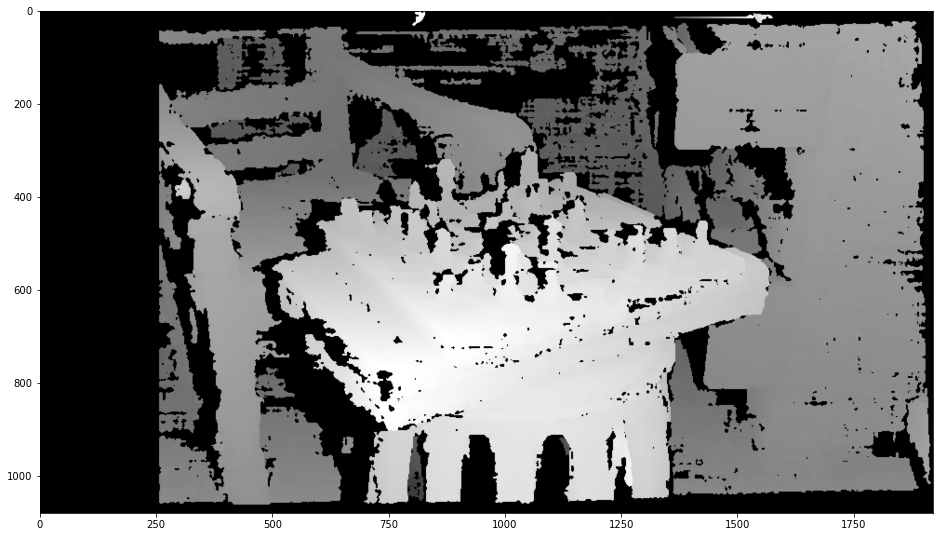

In [8]:
# show disparity map
iml_, imr_ = preprocess(img1_rectified, img2_rectified)
disp, _ = stereoMatchSGBM(iml_, imr_, True)
plt.imshow(disp,cmap="gray")
plt.show()

In [12]:
print(disp)

[[-2. -2. -2. ...  0.  0.  0.]
 [-2. -2. -2. ...  0.  0.  0.]
 [-2. -2. -2. ...  0.  0.  0.]
 ...
 [-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]]


In [9]:
nb=-193.001
Q=np.array([[1,0,0,-left_matrix[0,2]],
           [0,1,0,-left_matrix[1,2]],
           [0,0,0,left_matrix[0,0]],
           [0,0,-1/nb,(left_matrix[0,2]-right_matrix[0,2])/nb]])

points_3d = cv2.reprojectImageTo3D(disp, Q)
def hw3ToN3(points):
    height, width = points.shape[0:2]
    points_1 = points[:, :, 0].reshape(height * width, 1)
    points_2 = points[:, :, 1].reshape(height * width, 1)
    points_3 = points[:, :, 2].reshape(height * width, 1)
    points_ = np.hstack((points_1, points_2, points_3))
    return points_

points = hw3ToN3(points_3d)
colors = np.asarray(hw3ToN3(img1_rectified[:,:,::-1])/255)
idx = np.random.randint(0, points.shape[0], 50000)
sampled_points = points[idx]
sampled_color = colors[idx]

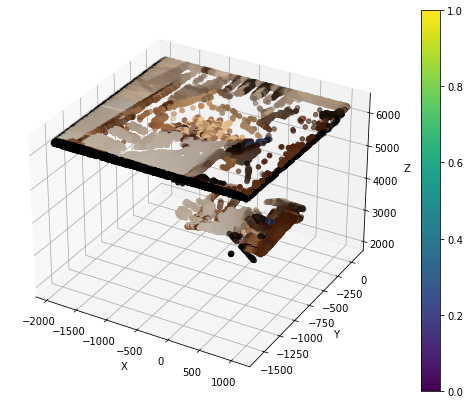

In [10]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(sampled_points[:,0], sampled_points[:,1], sampled_points[:,2], c = sampled_color)
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [11]:
import open3d as o3d
cloud = o3d.geometry.PointCloud()    #create a point cloud

cloud.points = o3d.utility.Vector3dVector(hw3ToN3(points_3d))    #define point cloud coordinates
color=np.asarray(hw3ToN3(img1_rectified[:,:,::-1])/255)
cloud.colors = o3d.utility.Vector3dVector(color)    #define point cloud color
R = cloud.get_rotation_matrix_from_xyz((np.pi, 0, 0))    #rotate cloud to visualize
cloud.rotate(R, center=(0, 0, 0))
o3d.visualization.draw_geometries([cloud])